# Final Report

## Introduction

We, Gideon Keith-Stanley and Tyler Short, strove to find out if we could use a natural language processing algorithm along with other machine learning techniques to determine if a video game description could predict, with any reliability, what genre(s) the game falls under. 

The PC Games 2020 dataset contains the results of scraping and sorting the entire catalog of Valve's "Steam" video game store, and includes data on over 27,000 titles. These data include title, description, genre, price points, several success metrics, and more. We hypothesize that using the "bag of words" method as seen in email spam filters, we can train a machine learning model using the digested description of video games, and use that information to classify games by genre.

The dataset itself has the following properties:
-30250 samples (games)
-27 features
    -Unnamed
    -id
    -Name
    -RawgID
    -SteamURL
    -Metacritic
    -Genres
    -Indie
    -Presence
    -Platform
    -Graphics
    -Storage
    -Memory
    -RatingsBreakdown
    -ReleaseDate
    -Soundtrack
    -Franchise
    -OriginalCost
    -DiscountedCost
    -Players
    -Controller
    -Languages
    -ESRB
    -Achievements
    -Publisher
    -Description
    -Tags

For our project we are only looking at Genres and Description.

## Data Capture

These methods were written to pull our data from the arff file. 

In [37]:
import numpy as np
import pandas as pd
import arff
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

def load_game_data():
    url = 'https://api.openml.org/data/v1/download/22102514/PC-Games-2020.arff'
    filename = 'pc_game_dataset.arff'
    file, http_response = urlretrieve(url, filename)
    dataset = arff.load(open(file, 'r'))
    attributes = np.array(dataset['attributes'])
    data = np.array(dataset['data'])
    data = clean_data(data)
    return data, attributes

# Use this to save bandwidth and time if the project has the data file already downloaded
def load_game_data_from_file():
    file = 'pc_game_dataset.arff'
    dataset = arff.load(open(file, 'r'))
    attributes = np.array(dataset['attributes'])
    data = np.array(dataset['data'])
    data = clean_data(data)
    return data, attributes

def clean_data(data):
    result = []
    for element in data:
        if element[6] != "" and element[6] is not None and element[25] != "" and element[25] is not None:
            result.append(element)
    return np.array(result)

A, b = load_game_data_from_file()

## Data Pre-Processing - Natural Language Processing with TfidfVectorizer

During this step, we first isolate our label vector 'genre' and convert it into a usable y for train and test sets. Once y_labels is populated with all of the available genres in a set (to prevent duplicates to be added), y is created by creating a vector of 1s (genre present) and 0s (genre absent) to give us a method for binary classification. In the end, each y is an ordered vector that contains N 0s and 1s where N is the number of genres and the 1 and 0s correlate to the one or more genres listed for the game.

For our X data matrix, we want to look at game descriptions, which in this case requires a strategy for Natural Language Processing. This allows us to quantify the words in the description for use in our machine learning algorithms. In our initial plan we wanted to implement the Box of Words algorithm, where we would 'tokenize' the words in each description compared to a ~20k word dictionary after removing stop words and create a number vector representing the presence of a dictionary word in the definition. 

However, we found that a scikit tool called TfidfVectorizor basically performed these same steps in a much easier to implement fashion so that is what we ultimately used as our NLP strategy for the X data matrix. This tool is a combination of two other scikit tools, CountVectorizer and TfidfTransformer. CountVectorizer does a lot of the work that Bag of Words did in quantifying and tokenizing the words in the descriptions. TfidfTransformer goes a step further and generates a data matrix from CountVectorizer that analyzes word frequency and "inverse document frequency"(the 'uniqueness' of a word) to further reduce the impact of 'noise' words in the descriptions. 

After the below code is run, the data previously captured is split into our familiar X data and y label variables. The X data matrix contains the information from the descriptions in the form of the TfidfTransformer matrix while the y label vector contains a list of arrays that correlate to the assigned genres for each matching game. 

In [38]:
import string

def process_string(subject):
    term = subject.strip()
    term = str.lower(term)
    term = term.translate(str.maketrans("","", string.punctuation))
    return term

results = set([])
genres = A[:,6]
for entry in genres:
    terms = str(entry).split(',')
    for term in terms:
        results.add(process_string(term))
y_labels = list(results)

y = []
for entry in A:
    y_row = [0] * len(y_labels)
    for genre in str(entry[6]).split(','):
        y_row[y_labels.index(process_string(genre))] = 1
    y.append(y_row)
    
    
y = np.array(y)

docs = [str(n) for n in A[:,25]]
tv = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, max_df=0.5, min_df=5, lowercase=True, stop_words='english')
tv_result = tv.fit_transform(docs)
X = tv_result

print(X.shape)
print(y.shape)

(27094, 22979)
(27094, 20)


### Data Distribution

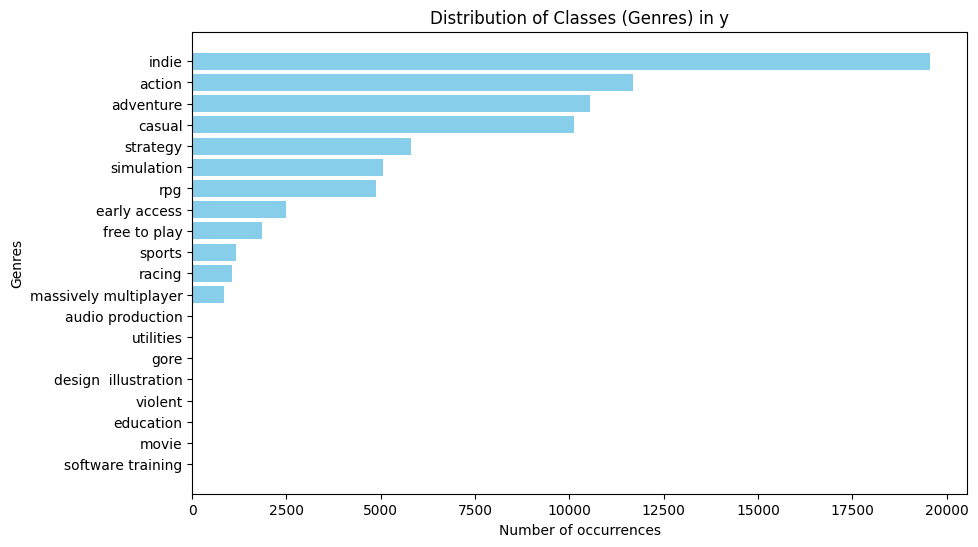

[ 2494 19563  1164     1     1 10550     2     1   838 11687  4870  5058
  5806  1053     1  1864     2 10112     1     1]


In [ ]:
class_counts = np.sum(y, axis=0)

y_labels_sorted = [y_labels[i] for i in np.argsort(class_counts)]

plt.figure(figsize=(10, 6))
plt.barh(y_labels_sorted, sorted(class_counts), color='skyblue')
plt.xlabel('Number of occurrences')
plt.ylabel('Genres')
plt.title('Distribution of Classes (Genres) in y')
plt.show()

## Analysis

[words about our methodology and using LinearSVC and RandomForest, maybe put discussion about hyperparameter testing here]

### LinearSVC

After preprocessing and generalizing the data, our first choice for modeling was the Support Vector Machine classifer LinearSVC. We chose a classifier model vs a regression model since our goal is to organize data based on labels/classifiers. Since most data can be classified using a Linear model this seemed like a good place to start, and with a small amount of work gave us an already high average of around 92.3%. In order to test hyperparameters we split the data in to train, test and validation sets and tested the training data against the validation set to calculate the optimal hyperparameters. Due to the nature of our y label vector, we used the OneVsRestClassifier with our LinearSVC model to train a classifier for each class due to the large number of classes. While it does increase complexity and runtime we found that it increases the performance of the model. After analyzing the classes as a whole, we also did analysis based on each genre individually and determined their accuracies that way. 

One thing to note, which is apparent in the distribution of classes and the classification report, is the low sample number for certain genres. This tended to skew our model toward an almost perfect success rate with these genres, but it appears that this was mostly due to an almost blanket guess of false for those genres(as shown in the confusion matrix). It is noteworthy that the model chose false for them which was correct in most cases but a larger amount of samples would be needed for futher study. 

##### Hyperparameter Tuning

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

size_test = 0.3
size_validation = 0.2
size_train = 0.5

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=size_test, random_state=5)

size_validation_rescaled = size_validation/(size_validation + size_train)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=size_validation_rescaled, random_state=5)

def svc_select_C(X_train, X_valid, y_train, y_valid, Cs) :
    accuracies = []
    for C in Cs : 
        classifier = OneVsRestClassifier(LinearSVC(C=C, loss='hinge', max_iter=50000))
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_valid)
        accuracy = np.mean(y_valid == y_pred)
        accuracies.append(accuracy)
        print(f"C: {C}\t accuracy: {accuracy:0.3f}")
    return Cs[np.argmax(accuracies)]

Cs = [.01, .1, .5, .9, 1, 10, 100]
hp = svc_select_C(X_train, X_valid, y_train, y_valid, Cs)
print(f"chosen value of C: {hp}")
classifier = OneVsRestClassifier(LinearSVC(C=hp, loss='hinge', max_iter=50000))
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f'accuracy on test set:  {np.mean(y_test == y_pred):0.3f}')

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 0.01	 accuracy: 0.883


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 0.1	 accuracy: 0.907


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 0.5	 accuracy: 0.921


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 0.9	 accuracy: 0.922


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 1	 accuracy: 0.922


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 10	 accuracy: 0.904


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.w

C: 100	 accuracy: 0.902
chosen value of C: 0.9


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(


accuracy on test set:  0.922


C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 18 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 19 is present in all training examples.
  warnings.warn(


##### Model Fitting

In [58]:
results = []
for state in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = state)
    classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    results.append(np.mean(y_pred == y_test))
print(f'accuracy on test set:  {np.mean(results):0.3f}')

KeyboardInterrupt: 

##### Classification Report

In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=y_labels, zero_division=1.0))


                       precision    recall  f1-score   support

         early access       0.64      0.05      0.09       755
                indie       0.82      0.93      0.87      5934
               sports       0.85      0.35      0.50       346
    software training       1.00      1.00      1.00         0
                movie       1.00      0.00      0.00         1
            adventure       0.71      0.62      0.66      3188
            utilities       1.00      1.00      1.00         0
            education       1.00      1.00      1.00         0
massively multiplayer       0.88      0.19      0.31       245
               action       0.77      0.69      0.73      3538
                  rpg       0.85      0.50      0.63      1523
           simulation       0.78      0.38      0.51      1545
             strategy       0.81      0.49      0.61      1749
               racing       0.91      0.50      0.65       328
              violent       1.00      1.00      1.00  

##### Confusion Matrix

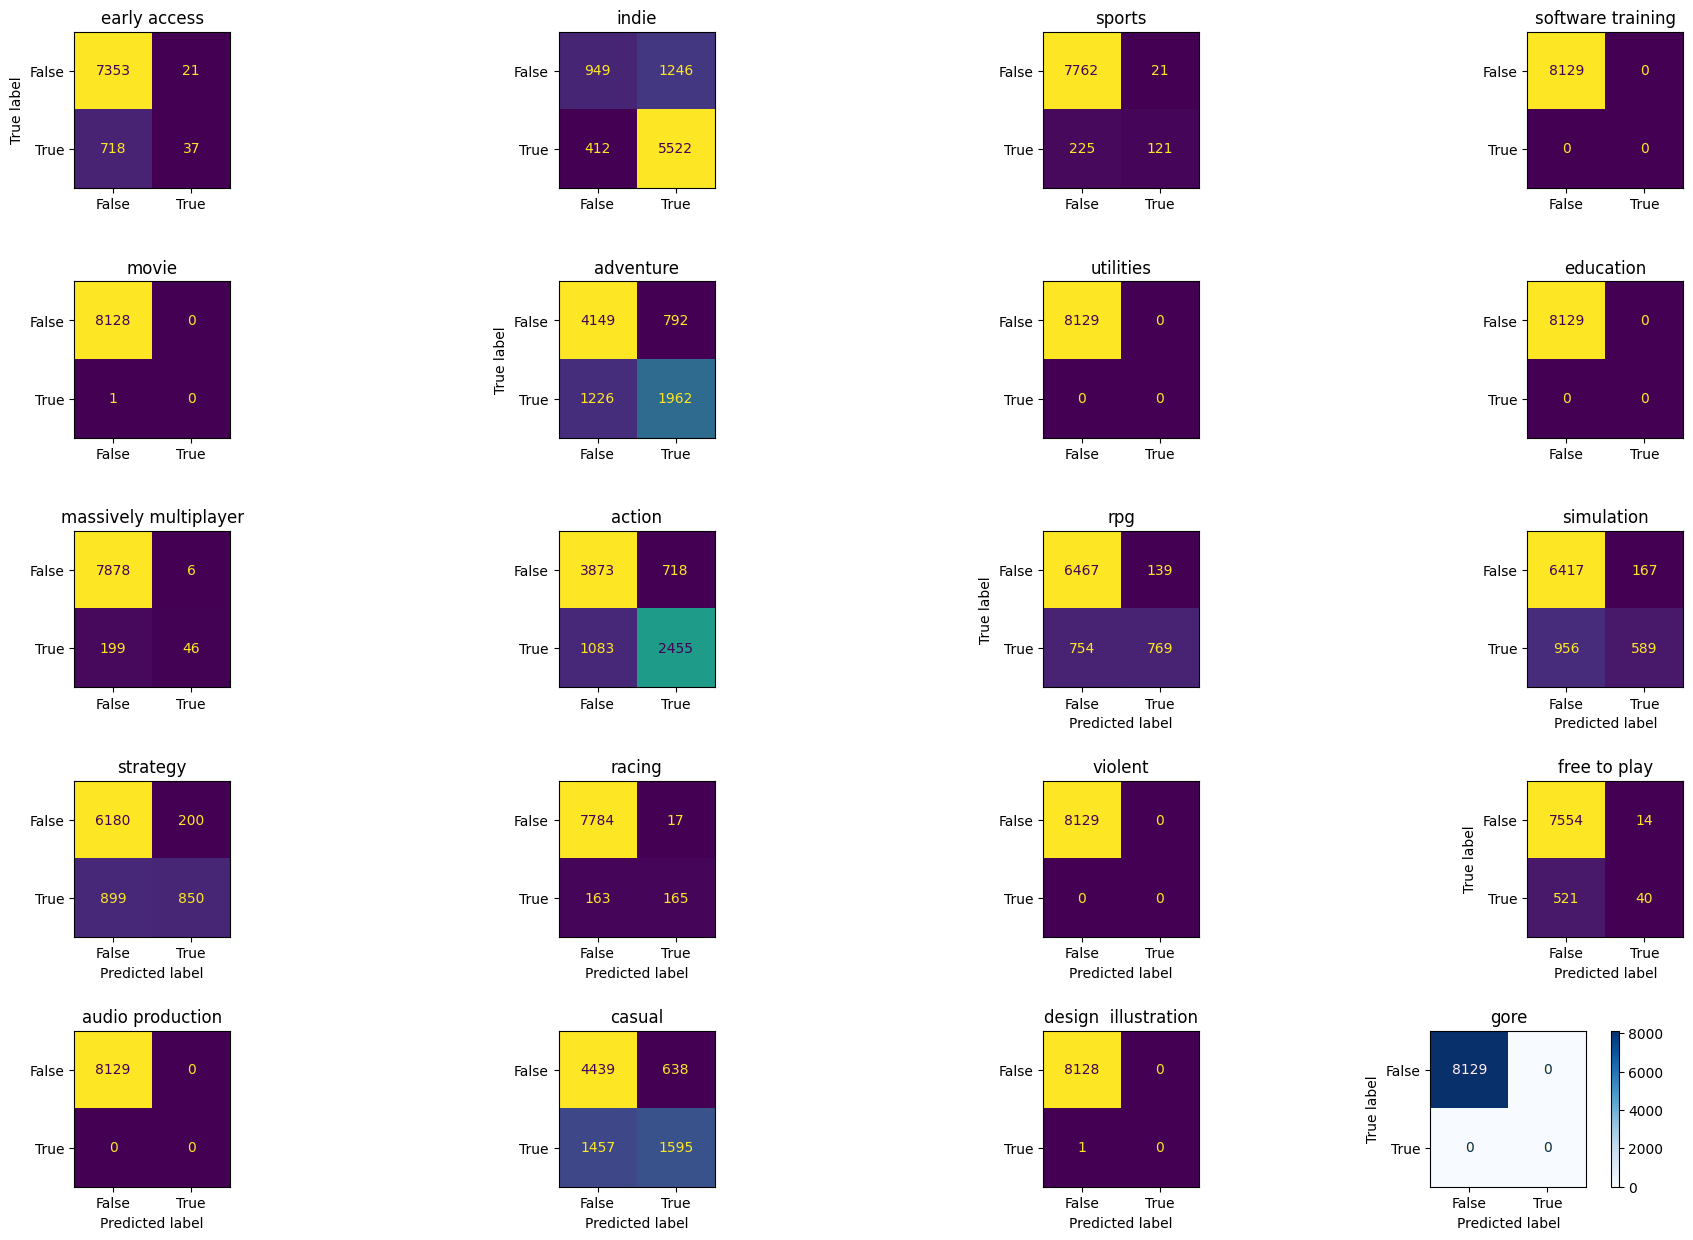

In [41]:
from sklearn.metrics import multilabel_confusion_matrix as mcm
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf = mcm(y_test, y_pred)

f, axes = plt.subplots(5, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(len(conf)):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf[i], display_labels=("False", "True"))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(y_labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0, hspace=0.6)
disp.plot(ax=plt.gca(), include_values=True, cmap=plt.cm.Blues)
plt.show()

##### Accuracy by Genre

In [42]:
genres = []
accuracy = []

for z in range(len(y_labels)):
    tmp = y[:,z]
    results = []
    for state in range(10):
        x_train, x_test, y_train, y_test = train_test_split(X, tmp, test_size = 0.3, random_state = state)
        classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        results.append(np.mean(y_pred == y_test))
    genres.append(y_labels[z])
    accuracy.append(np.mean(results))

C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
C:\Users\tbsho\AppData\Roaming\Python\Python312\site-packages\sklearn\multiclass.py:87: UserWarning: Label not 0 is present in all training examples.
  warnings.warn

In [43]:
df = pd.DataFrame(accuracy, genres)
df

,0
early access,0.911600
indie,0.795535
sports,0.969640
software training,0.999988
movie,0.999938
adventure,0.754226
utilities,0.999975
education,0.999988
massively multiplayer,0.973736
action,0.782605


### RandomForest

As an alternative to large margin classification, we also wanted to try a different approach using decision trees. For this dataset we decided to use RandomForest, as it would allow us to also benefit from its bagging function. True to its nature, the RandomForest did come close to the accuracy displayed by our LinearSVC, which gave us confidence in our data and the models we were using. Similar hyperparamater tuning and genre distribution were performed with this modeling to see the difference between the two models. Overall, the RandomForest seemed to be a little less accurate but otherwise consistent with the LinearSVC model with an average accuracy of 91.1%

##### Hyperparameter Tuning

In [55]:
from sklearn.ensemble import RandomForestClassifier

size_test = 0.3
size_validation = 0.2
size_train = 0.5

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=size_test, random_state=5)

size_validation_rescaled = size_validation/(size_validation + size_train)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=size_validation_rescaled, random_state=5)

def rf_select_mss(X_train, X_valid, y_train, y_valid, mss) :
    accuracies = []
    for m in mss : 
        classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=m)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_valid)
        accuracy = np.mean(y_valid == y_pred)
        accuracies.append(accuracy)
        print(f"mss: {m}\t accuracy: {accuracy:0.3f}")
    return mss[np.argmax(accuracies)]

mss = [2,3,4,5,6]
mss = rf_select_mss(X_train, X_valid, y_train, y_valid, mss)
print(f"chosen value of mss: {mss}")
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=mss)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(f'accuracy on test set:  {np.mean(y_test == y_pred):0.3f}')

mss: 2	 accuracy: 0.909
mss: 3	 accuracy: 0.909
mss: 4	 accuracy: 0.909
mss: 5	 accuracy: 0.910
mss: 6	 accuracy: 0.910
chosen value of mss: 5
accuracy on test set:  0.911


##### Model Fitting

In [ ]:
results = []
for state in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = state)
    classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_split=3)
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    results.append(np.mean(y_pred == y_test))
print(f'accuracy on test set:  {np.mean(results):0.3f}')

0.911744987083282


##### Classification Report

In [45]:
print(classification_report(y_test, y_pred, target_names=y_labels, zero_division=1.0))

                       precision    recall  f1-score   support

         early access       0.55      0.06      0.10       755
                indie       0.76      0.98      0.85      5934
               sports       0.68      0.08      0.14       346
    software training       1.00      1.00      1.00         0
                movie       1.00      0.00      0.00         1
            adventure       0.76      0.52      0.61      3188
            utilities       1.00      1.00      1.00         0
            education       1.00      1.00      1.00         0
massively multiplayer       0.60      0.09      0.15       245
               action       0.79      0.63      0.70      3538
                  rpg       0.75      0.17      0.28      1523
           simulation       0.72      0.14      0.24      1545
             strategy       0.79      0.24      0.36      1749
               racing       0.82      0.17      0.28       328
              violent       1.00      1.00      1.00  

##### Confusion Matrix

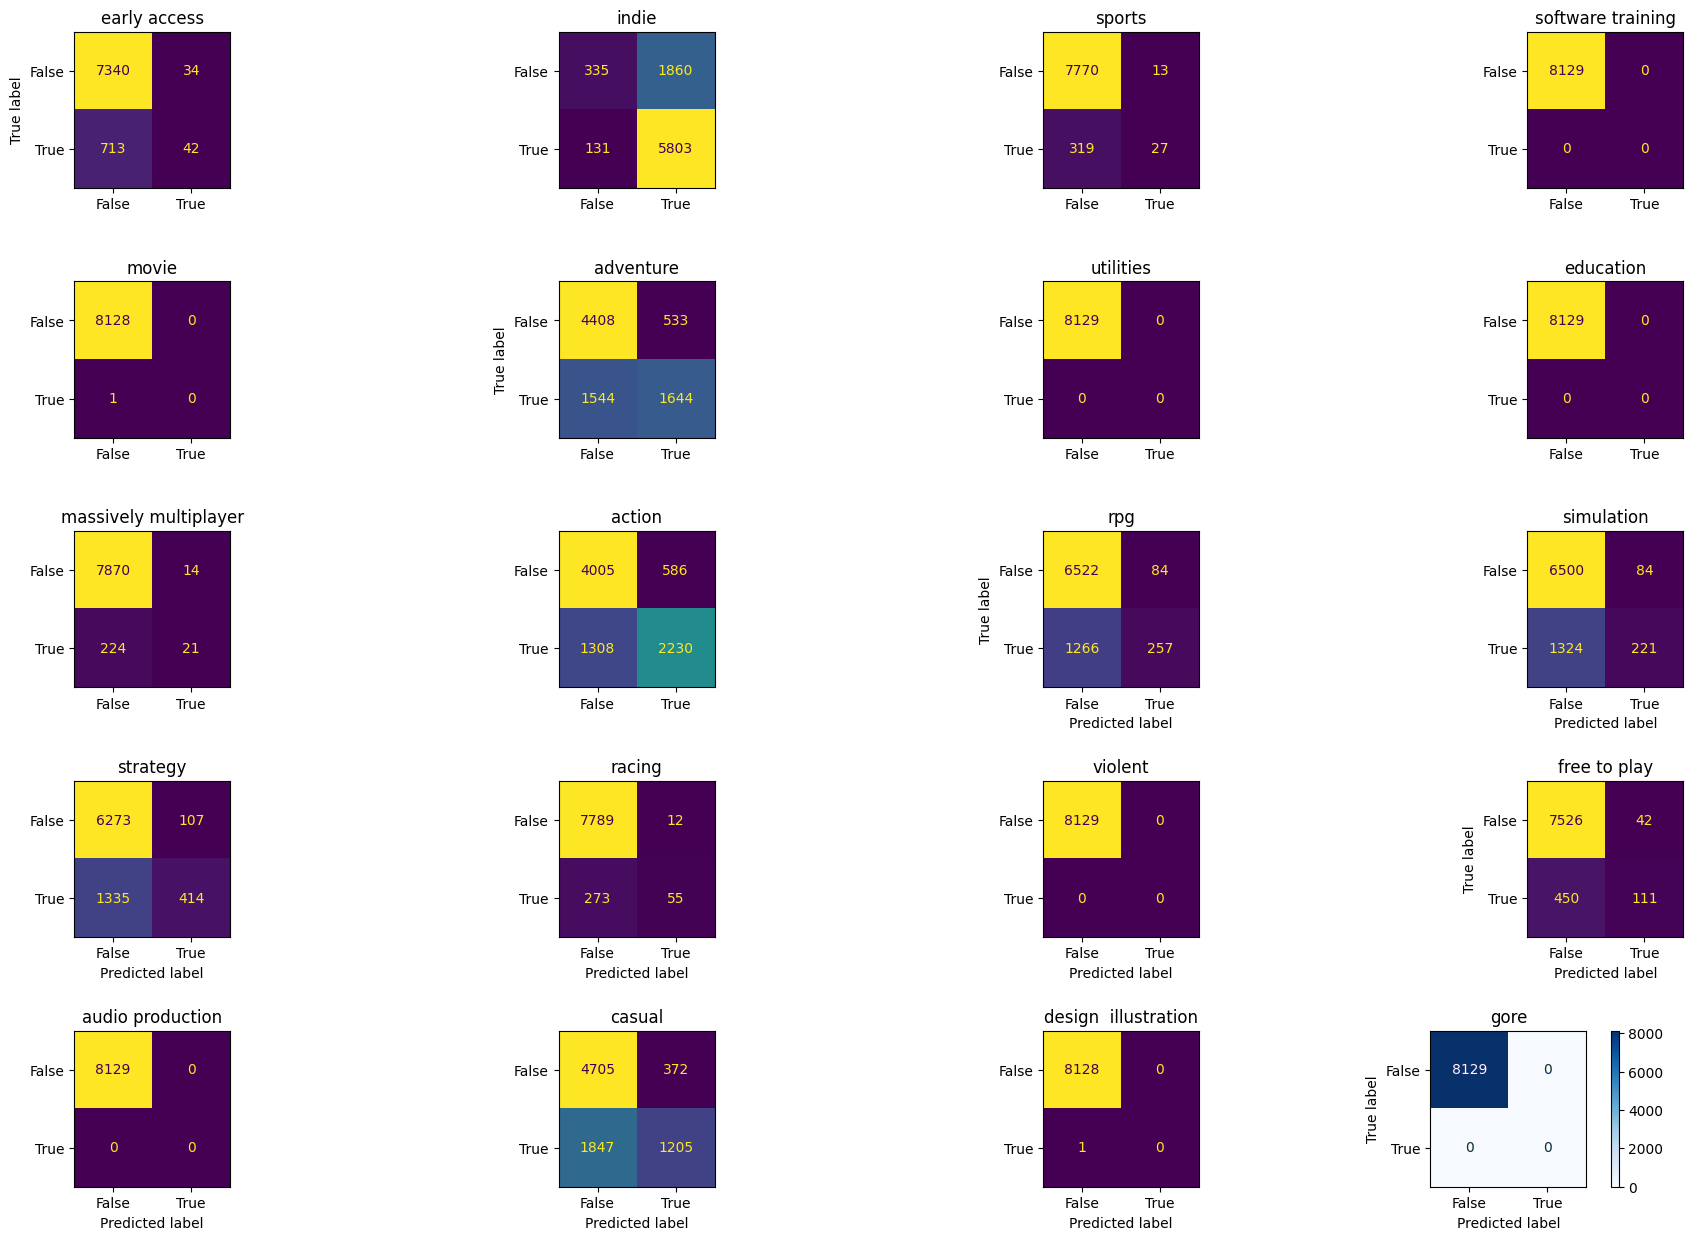

In [46]:
conf = mcm(y_test, y_pred)

f, axes = plt.subplots(5, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(len(conf)):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf[i], display_labels=("False", "True"))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(y_labels[i])
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0, hspace=0.6)
disp.plot(ax=plt.gca(), include_values=True, cmap=plt.cm.Blues)
plt.show()

##### Accuracy by Genre

In [47]:
genres = []
accuracy = []
for z in range(len(y_labels)):
    tmp = y[:,z]
    results = []
    for state in range(10):
        x_train, x_test, y_train, y_test = train_test_split(X, tmp, test_size = 0.3, random_state = state)
        classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        classifier.fit(x_train,y_train)
        y_pred = classifier.predict(x_test)
        results.append(np.mean(y_pred == y_test))
    genres.append(y_labels[z])
    accuracy.append(np.mean(results))

In [48]:
df = pd.DataFrame(accuracy, genres)
df

,0
early access,0.909620
indie,0.765186
sports,0.961803
software training,0.999988
movie,0.999914
adventure,0.753426
utilities,0.999951
education,0.999988
massively multiplayer,0.970378
action,0.779715


## Sample Testing

This code allows one to enter specific game data to test out the model on the fly! 

In [59]:
sample_testing_results = []

In [60]:
title = "Noita"
description = ["Noita is a magical action roguelite set in a world where every pixel is physically simulated. Fight, explore, melt, burn, freeze and evaporate your way through the procedurally generated world using spells you've created yourself."]
actual = ["action", "adventure", "indie", "rpg", "simulation"]

In [61]:
classifier = OneVsRestClassifier(LinearSVC(C=0.9, loss='hinge', max_iter=50000))
classifier.fit(X, y)
print("Classifier Trained")

Classifier Trained


In [62]:
sample = TfidfVectorizer(vocabulary=tv.vocabulary_, smooth_idf=True, sublinear_tf=True, max_df=0.5, min_df=5, lowercase=True, stop_words='english')
sample_result = sample.fit_transform(description)
y_pred = classifier.predict(sample_result)

result = []
for label in range(len(y_labels)):
    if y_pred[0][label] != 0:
        result.append(y_labels[label])

trained = np.isin(title, A[:, 2])
correct = 0
incorrect = 0
for genre in result:
    if genre in actual:
        correct += 1
    else:
        incorrect += 1
correct_ratio = "" + str(correct) + "/" + str(len(actual))
test_output = [trained, title, description[0], actual, result, correct_ratio, incorrect]


sample_testing_results.append(test_output)

columns = ['Already in training set', 'Title', 'Description', 'Actual genres', 'Predicted Genres', 'Correct Genres', 'Incorrect Genres']
pd.DataFrame(sample_testing_results, columns=columns)

,Already in training set,Title,Description,Actual genres,Predicted Genres,Correct Genres,Incorrect Genres
0,True,Noita,Noita is a magical action roguelite set in a w...,"[action, adventure, indie, rpg, simulation]","[indie, adventure, action]",3/5,0


## Conclusions

Analyzing the PC Games 2020 dataset allowed us to learn a new data processing technique, as well as continue develop skills we had previously learned. Using Natural Language Processing, we were able to translate data consisting of word strings from video game descriptions into quantifiable data in a feature matrix using TfidfVectorizer, which is a sophisticated tool to implement the Box of Words strategy for language processing. This process includes removing common words ('stopwords') and then tokenizing the remaining words in the description based off of a previously selected dictionary of words, along with steps for data generalization if necessary. 

After this data was properly processed and generalized, we used two models to analyze and predict the data: LinearSVC and RandomForest. LinearSVC, our hard margin classifier, needed some boosting with the OneVsRestClassifier, but after that was applied and hyperparameter tuning was performed we got promising results! After using validation sets for hyperparameter tunining the models were fitted and gave us surprisingly high average accuracies: 92.3% for LinearSVC and 91.1% for RandomForest. We do recognize that these accuracies are skewed by the small sample size of some of the classes, but are still happy with the fact that most other genres lie in the 70-80~ percent accuracy range.